Ref:
- Andrew Ngs videos (the course in the specializaiton)
- 3b1b convolution video
- the independent code
- cs231n notes

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL to tensor
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))  # Normalize with CIFAR-10 mean/std
])


In [3]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = trainset.classes  # class names


100%|██████████| 170M/170M [00:05<00:00, 29.2MB/s]


In [5]:
print(type(trainset))
print(trainset[0])

<class 'torchvision.datasets.cifar.CIFAR10'>
(tensor([[[-1.2854e+00, -1.5955e+00, -1.4598e+00,  ...,  6.3375e-01,
           5.1744e-01,  4.3990e-01],
         [-2.1189e+00, -2.4291e+00, -2.0801e+00,  ..., -4.4721e-02,
          -1.2226e-01, -6.4106e-02],
         [-1.9444e+00, -2.1189e+00, -1.4792e+00,  ..., -1.4165e-01,
          -1.0288e-01, -3.1611e-01],
         ...,
         [ 1.6030e+00,  1.4673e+00,  1.4091e+00,  ...,  6.7252e-01,
          -1.3435e+00, -1.4017e+00],
         [ 1.0602e+00,  9.2452e-01,  1.1765e+00,  ...,  1.1378e+00,
          -5.4873e-01, -8.2012e-01],
         [ 1.0021e+00,  8.2760e-01,  1.0408e+00,  ...,  1.7581e+00,
           4.9806e-01, -4.4721e-02]],

        [[-1.1989e+00, -1.5136e+00, -1.4742e+00,  ...,  1.7777e-01,
           4.0101e-02,  2.0434e-02],
         [-2.0249e+00, -2.4183e+00, -2.2609e+00,  ..., -6.8757e-01,
          -7.8591e-01, -7.0724e-01],
         [-1.9463e+00, -2.2806e+00, -1.8873e+00,  ..., -7.6624e-01,
          -7.6624e-01, -9.8258

In [6]:
len(trainset)

50000

In [7]:
len(testset)

10000

In [8]:
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [19]:
def unnormalize_image(img):
    mean = torch.tensor([0.4914, 0.4822, 0.4465], device=img.device).view(3, 1, 1)
    std = torch.tensor([0.2023, 0.1994, 0.2010], device=img.device).view(3, 1, 1)
    return (img * std + mean).clamp(0, 1)

# cifar image is (3,32,32)
def imshow(img):
    img = unnormalize_image(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.show()


In [12]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

# imshow(torchvision.utils.make_grid(images[:8]))
# print('Labels:', '  '.join(f'{classes[labels[j]]}' for j in range(8)))


In [14]:
print(type(images))
print(images.shape)
print(type(labels))
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 3, 32, 32])
<class 'torch.Tensor'>
torch.Size([64])


In [15]:
im1 = images[0]
l1 = labels[0]
print(im1.shape)
print(l1)

torch.Size([3, 32, 32])
tensor(6)


In [20]:
grid = torchvision.utils.make_grid(images[:8])
print(type(grid))
print(grid.shape) # [3, 32, 8 * 32 + padding] → [3, 32, 274] (since default padding=2)


<class 'torch.Tensor'>
torch.Size([3, 36, 274])


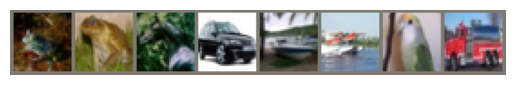

Labels: frog  frog  horse  automobile  ship  airplane  bird  truck


In [21]:
imshow(grid)
print('Labels:', '  '.join(f'{classes[labels[j]]}' for j in range(8)))

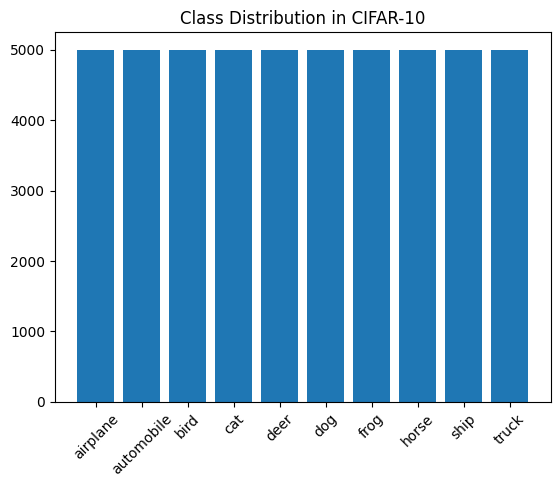

In [22]:
from collections import Counter

labels_list = [label for _, label in trainset]
class_counts = Counter(labels_list)
plt.bar(classes, [class_counts[i] for i in range(10)])
plt.xticks(rotation=45)
plt.title("Class Distribution in CIFAR-10")
plt.show()


For label 6


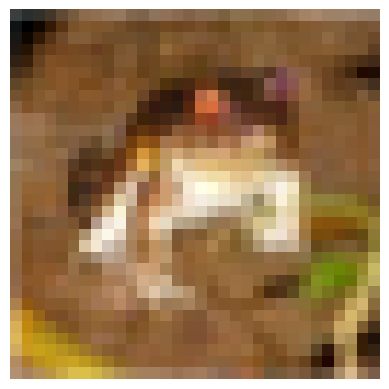

Label: frog
For label 9


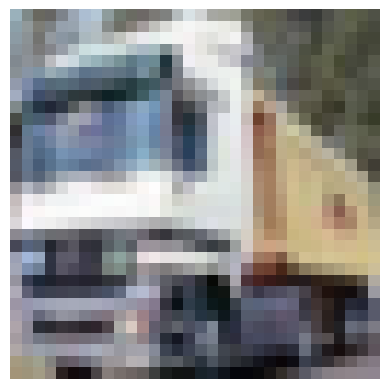

Label: truck
For label 4


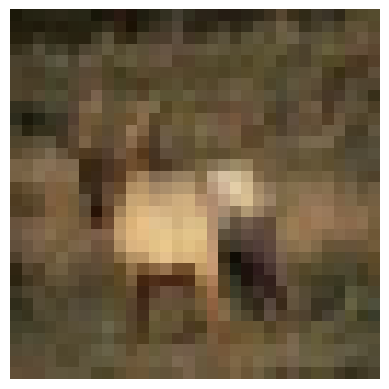

Label: deer
For label 1


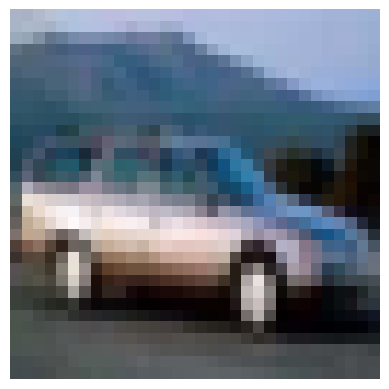

Label: automobile
For label 2


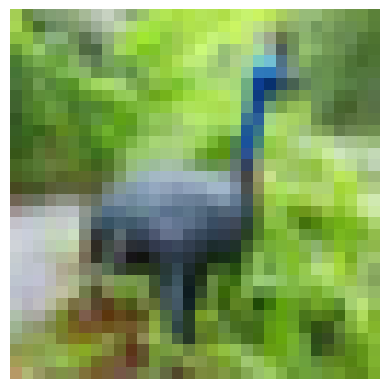

Label: bird
For label 7


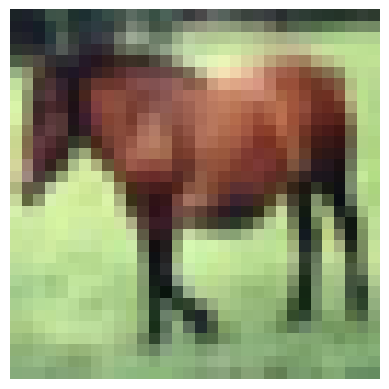

Label: horse
For label 8


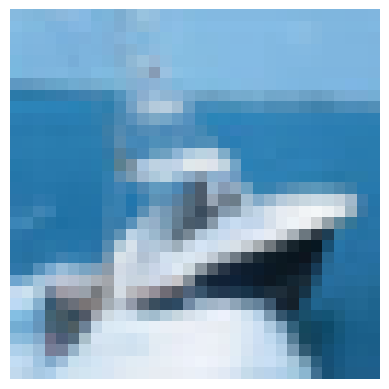

Label: ship
For label 3


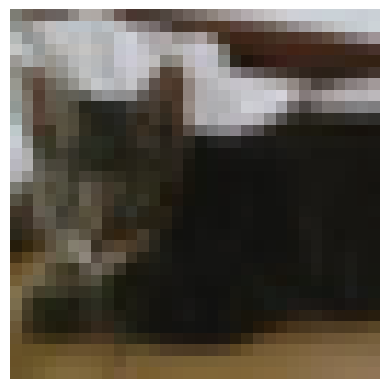

Label: cat
For label 5


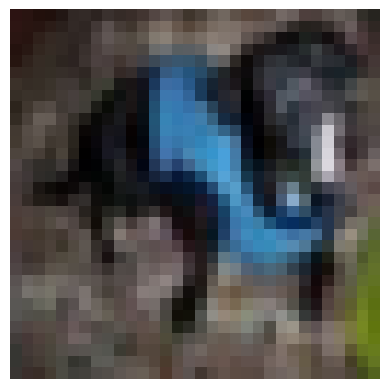

Label: dog
For label 0


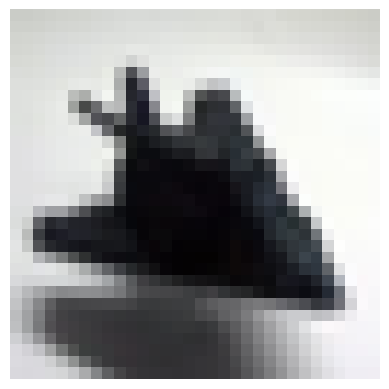

Label: airplane


In [24]:
seen = set()
images_per_class = {}

for img, label in trainset:
    if label not in seen:
        images_per_class[label] = img
        seen.add(label)
    if len(seen) == 10:
        break

for i, img in images_per_class.items():
  print(f"For label {i}")
  imshow(img)
  print(f"Label: {classes[i]}")

In [25]:
import torch.nn as nn
import torch.nn.functional as F

class MiniCNN1(nn.Module):
    def __init__(self):
        super(MiniCNN1, self).__init__()
        # in channels, out channels
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)   # (B, 3, 32, 32) → (B, 8, 32, 32)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)  # → (B, 16, 32, 32)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1) # → (B, 32, 32, 32)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(32 * 4 * 4, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x1 = self.pool(x)
        x = F.relu(self.conv2(x1))
        x2 = self.pool(x)
        x = F.relu(self.conv3(x2))
        x3 = self.pool(x)
        out = x3.view(x3.size(0), -1)
        out = self.fc(out)
        return out, (x1, x2, x3)  # return intermediate features


In [26]:
model1 = MiniCNN1().to(device)

import torch.optim as optim

criterion = nn.CrossEntropyLoss() # this combines the softmax wiht nnloss
optimizer = optim.Adam(model1.parameters(), lr=0.001)


In [27]:
def train(model, trainloader, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs, _ = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader):.4f}")


In [31]:
num_params = sum(p.numel() for p in model1.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_params}")

Number of trainable parameters: 11162


In [29]:
train(model1, trainloader, epochs=5)


Epoch 1, Loss: 1.5775
Epoch 2, Loss: 1.2619
Epoch 3, Loss: 1.1343
Epoch 4, Loss: 1.0560
Epoch 5, Loss: 0.9932


In [32]:
def evaluate(model, testloader):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs, _ = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Test Accuracy: {100 * correct / total:.2f}%")


In [33]:
evaluate(model1, testloader)

Test Accuracy: 64.91%


In [34]:
dataiter = iter(testloader)
images, labels = next(dataiter)
print(type(images), images.shape, type(labels), labels.shape, type(images[0]),images[0].shape)
im = images[0].unsqueeze(0)
print(im.shape, type(im))
img = im.to(device)
label = labels[0].item()
print(label)

<class 'torch.Tensor'> torch.Size([64, 3, 32, 32]) <class 'torch.Tensor'> torch.Size([64]) <class 'torch.Tensor'> torch.Size([3, 32, 32])
torch.Size([1, 3, 32, 32]) <class 'torch.Tensor'>
3


In [35]:
model1.eval()
with torch.no_grad():
    _, (x1, x2, x3) = model1(img)


In [41]:
print(type(x1),"\n", x1.shape )
print(type(x2), "\n", x2.shape)
print(type(x3), "\n", x3.shape)

<class 'torch.Tensor'> 
 torch.Size([1, 8, 16, 16])
<class 'torch.Tensor'> 
 torch.Size([1, 16, 8, 8])
<class 'torch.Tensor'> 
 torch.Size([1, 32, 4, 4])


In [37]:
import matplotlib.pyplot as plt

def plot_feature_maps(activation, layer_name, max_channels=6):
    act = activation.squeeze(0).cpu()  # shape (C, H, W)
    num_channels = min(max_channels, act.shape[0])

    plt.figure(figsize=(15, 5))
    for i in range(num_channels):
        plt.subplot(1, num_channels, i + 1)
        plt.imshow(act[i], cmap='gray')
        plt.title(f'{layer_name} - Channel {i}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()



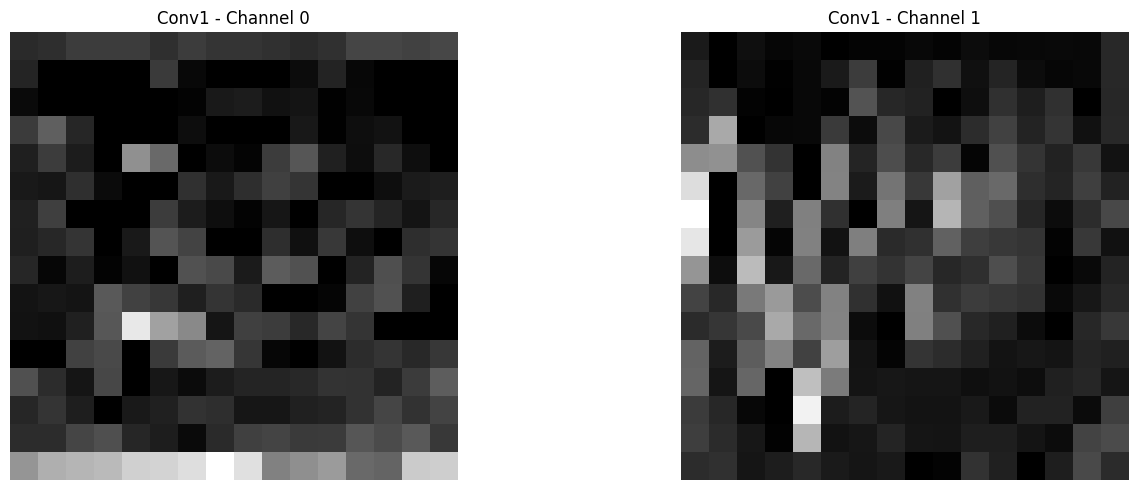

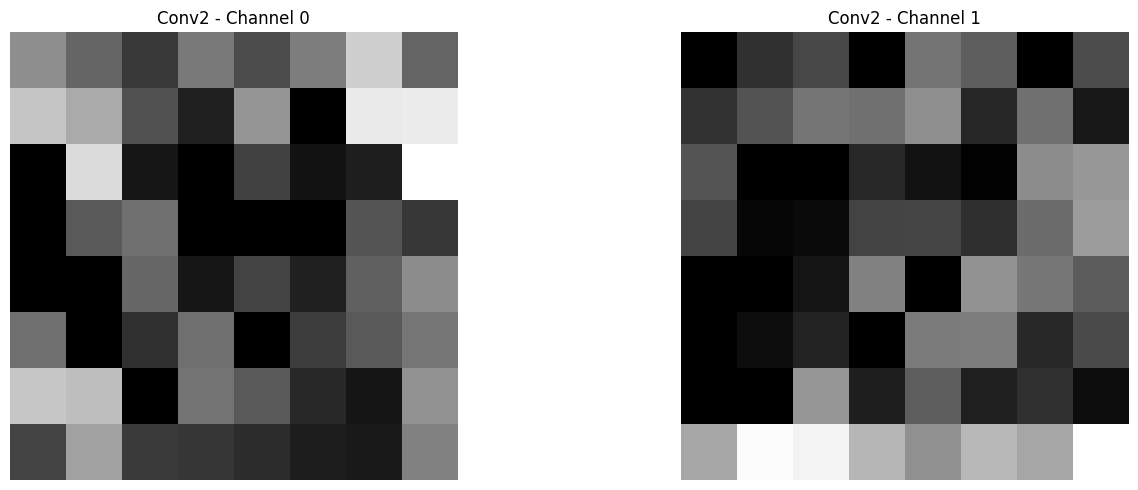

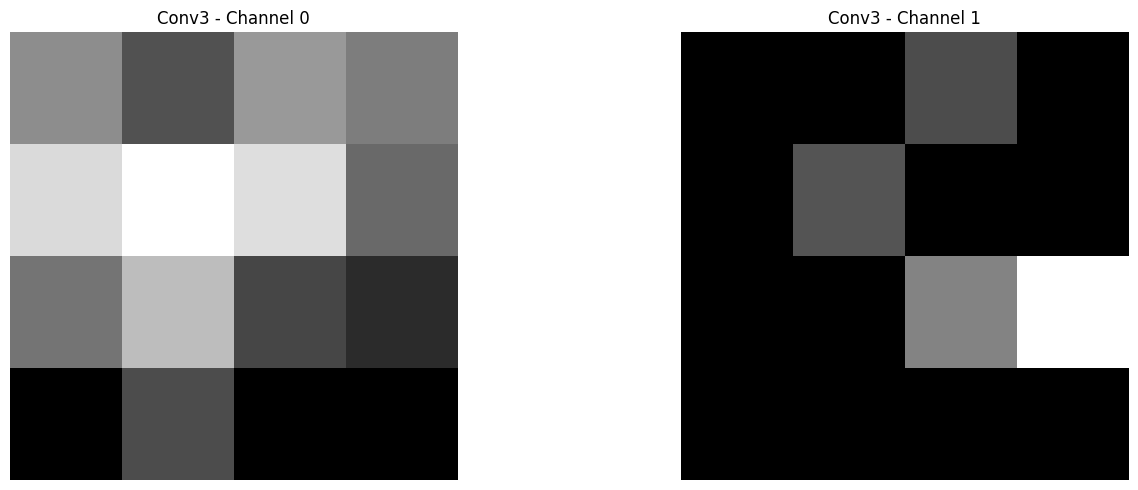

In [42]:
plot_feature_maps(x1, 'Conv1',2) # this is 16 by 16
plot_feature_maps(x2, 'Conv2',2)
plot_feature_maps(x3, 'Conv3',2)

In [45]:
def imshow2(img_tensor, title=None):
    img = img_tensor.squeeze(0).detach().cpu()  # shape: (3, 32, 32)

    # Unnormalize CIFAR-10
    img = img * torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1) + \
               torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)

    img = img.numpy().transpose(1, 2, 0)  # now shape: (32, 32, 3)

    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()


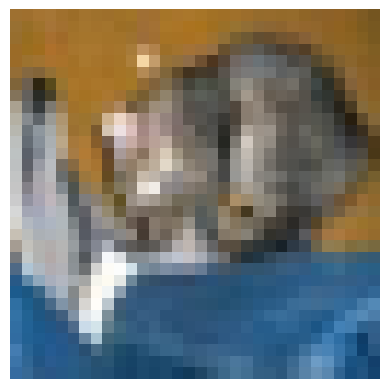

In [47]:
imshow2(img)

In [50]:
classes[label]

'cat'

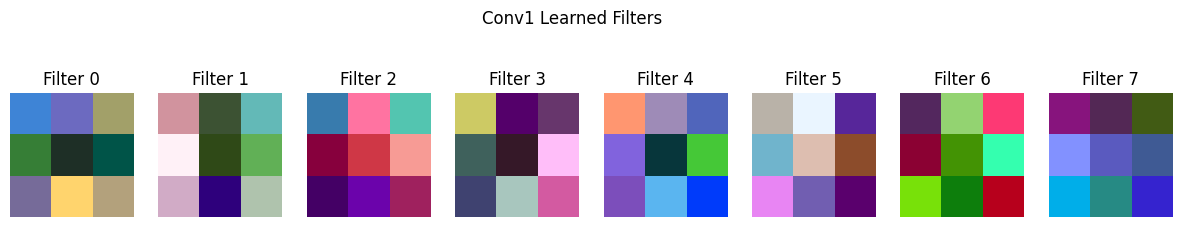

In [43]:
def visualize_filters(conv_layer, max_filters=8):
    weights = conv_layer.weight.data.clone().cpu()
    fig, axs = plt.subplots(1, max_filters, figsize=(15, 3))
    for i in range(max_filters):
        filt = weights[i]
        filt = (filt - filt.min()) / (filt.max() - filt.min())  # normalize to 0–1
        axs[i].imshow(np.transpose(filt.numpy(), (1, 2, 0)))
        axs[i].axis('off')
        axs[i].set_title(f'Filter {i}')
    plt.suptitle("Conv1 Learned Filters")
    plt.show()

# Call it for conv1
visualize_filters(model1.conv1)
